## CNN Classifier Testscript - Vacation Images


### Imports

In [1]:
#general
import numpy as np
import splitfolders
import time
from datetime import datetime 
from time import gmtime, strftime
from tqdm import tqdm

#pytorch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

#visualization
import matplotlib.pyplot as plt

### Some parameters to be set

In [2]:
#==============#
version = 'test'
#==============#
batch_size = 8
#==============#
epochs = 10
#==============#
lr = 0.001
#==============#
momentum = 0.9
#==============#
num_workers = 4
#==============#

### Script Runtime Start

In [3]:
def start_time_():    
    start_time = time.time()
    return(start_time)

def end_time_():
    end_time = time.time()
    return(end_time)

def Execution_time(start_time_,end_time_):
    return(strftime("%H:%M:%S",gmtime(int('{:.0f}'.format(float(str((end_time_-start_time_))))))))

In [4]:
script_start = start_time_()

### Initialize GPU

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Creating Folder Structure

The original folder containing the 2 subclass folder has to be split into subfolders for train, validation and test.

`Original:`  
* Data
    * Person
    * Scene
---
`New:`
* Data
    * train (70% of total)
        * Person
        * Scene
    * val (10% of total)
        * Person
        * Scene
    * test (20% of total)
        * Person
        * Scene

In [6]:
## Following Code does the described above

# input_folder = 'Data/'
# output_folder = 'img_data/'

# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.7, 0.1, 0.2))

In [7]:
#paths to be used for dataloaders later on
path_to_train = './img_data/train/'
path_to_val = './img_data/val/'
path_to_test = './img_data/test/'

### Define data tranformations

In [8]:
mean = [0.4939, 0.5189, 0.5326] #calculated in seperate notebook file
std = [0.2264, 0.2398, 0.2707] #calculated in seperate notebook file


#for training a litte augmentation (random flip, grayscale and rotation) will be performed
train_transforms = T.Compose([
    T.Resize([128,]),
    T.CenterCrop([128,]),
    T.RandomHorizontalFlip(0.3), 
    T.RandomGrayscale(0.1),
    T.RandomRotation(30),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
val_transforms = T.Compose([
    T.Resize([128,]),
    T.CenterCrop([128,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

#no augmentation needed, therefore only reszing, to tensor and normalizing
test_transforms = T.Compose([
    T.Resize([128,]),
    T.CenterCrop([128,]),
    T.ToTensor(),
    T.Normalize(torch.tensor(mean), torch.tensor(std))
])

### Initialize Datasets (Train, Validation, Test)

In [9]:
#Create datasets, labling is done with "ImageFolder"-Method
train_dataset = torchvision.datasets.ImageFolder(root=path_to_train, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=path_to_val, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=path_to_test, transform=test_transforms)

classes = ('person', 'scene')

### Initialize DataLoaders for the Datasets

In [10]:
#Define Loaders
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

### Unnormalize pictures for visualization later

In [11]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

### Define Image viewer

In [12]:
def imshow(img):
    de_norm = UnNormalize(mean=(0.4939, 0.5189, 0.5326), std=(0.2264, 0.2398, 0.2707))
    img = de_norm(img)      # unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

### Define CNN 

In [13]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #input_dim = 128, output_dim = 124
        self.pool = nn.MaxPool2d(2,2) #(kernelsize, stride)
        self.conv2 = nn.Conv2d(6, 16, 5, padding = 1) # input_dim = 62 (after pooling). output_dim (after 2nd pooling) = 30
        self.conv3 = nn.Conv2d(16, 16, 5) # input_dim = 30 , output_dim (after 3rd pooling)= 13
        
        self.fc1 = nn.Linear(16 * 13 * 13, 120) #(16 channel * 13 * 13 (image size))
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 2)
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [14]:
cnn = CNN().to(device)

### Define loss function and optimizer

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=lr, momentum=momentum)

### Train network

In [16]:
#splitted from below, to run more epochs if needed without setting loss lists to zero
train_loss = []  
validation_loss = []
min_valid_loss = np.inf  #value to distinguish if model will be saved or not. If val loss lower, model will be saved

In [17]:
#Starting Time 
train_start = start_time_()


#Training Iterations
#==========================================================================
for epoch in range(epochs):  # loop over the dataset multiple times
    
    
    #model training
    #______________________________________________________
    running_loss = 0.0
    cnn.train()
    for data, labels in tqdm(train_loader, leave=False):
        data, labels = data.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))
    
    
    #model validation
    #______________________________________________________
    valid_loss = 0.0
    cnn.eval()
    for data, labels in tqdm(val_loader, leave=False):
        data, labels = data.to(device), labels.to(device)
        
        outputs = cnn(data)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
    validation_loss.append(valid_loss / len(val_loader))
    
    
    #console output for tracking
    #______________________________________________________
    print(f'Epoch {epoch+1} \t\t Training Loss: {running_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
     
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
         
        # Saving State Dict
        torch.save(cnn.state_dict(), f'models/cnn_net_b{batch_size}_e{epochs}_{version}.pth') 
        
        
#==========================================================================


print('Finished Training')

#End Time of Training
train_end = end_time_()

#Time needed for training
print("Execution time of training is :", Execution_time(train_start, train_end))

  0%|                                                                                          | 0/261 [00:00<?, ?it/s]c:\users\matze\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 1 		 Training Loss: 0.674104689866647 		 Validation Loss: 0.6780895355500673
Validation Loss Decreased(inf--->25.767402) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 2 		 Training Loss: 0.6719785494822652 		 Validation Loss: 0.6757090421099412
Validation Loss Decreased(25.767402--->25.676944) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 3 		 Training Loss: 0.6657703153475034 		 Validation Loss: 0.6547011780111414
Validation Loss Decreased(25.676944--->24.878645) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 4 		 Training Loss: 0.630558934134085 		 Validation Loss: 0.742043023830966


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 5 		 Training Loss: 0.614762264764172 		 Validation Loss: 0.5865246826096585
Validation Loss Decreased(24.878645--->22.287938) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 6 		 Training Loss: 0.5950442447516197 		 Validation Loss: 0.5890306889226562


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 7 		 Training Loss: 0.5795289315711493 		 Validation Loss: 0.5569627990848139
Validation Loss Decreased(22.287938--->21.164586) 	 Saving The Model


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 8 		 Training Loss: 0.5446479693340616 		 Validation Loss: 0.5731762812325829


  0%|                                                                                          | 0/261 [00:00<?, ?it/s]

Epoch 9 		 Training Loss: 0.5158487472155086 		 Validation Loss: 0.5067412947353563
Validation Loss Decreased(21.164586--->19.256169) 	 Saving The Model


Epoch 10 		 Training Loss: 0.48993378249621483 		 Validation Loss: 0.48185725980683375
Validation Loss Decreased(19.256169--->18.310576) 	 Saving The Model
Finished Training
Execution time of training is : 00:11:33


### Save Model (now integrated in training loop)

In [18]:
# PATH = './cnn_net.pth'
# torch.save(cnn.state_dict(), PATH)

#Loading the model
#cnn = CNN()
#cnn.load_state_dict(torch.load(PATH))

### Show loss over epochs

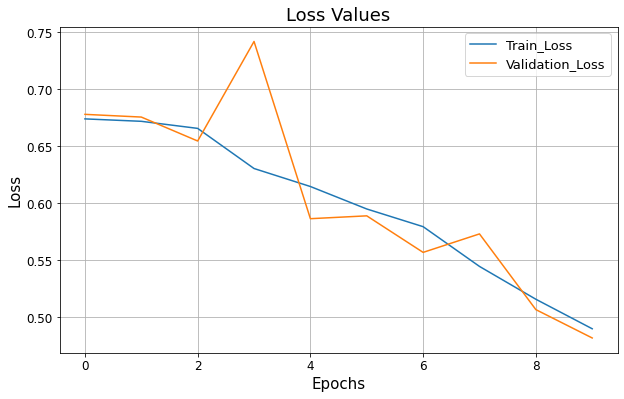

In [19]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train_Loss')
plt.plot(validation_loss, label='Validation_Loss')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=13)
plt.tick_params(labelsize=12)
plt.grid()
plt.title('Loss Values', fontsize=18)
plt.savefig(f'graphs/loss_b{batch_size}_e{epochs}_{version}.png', dpi=300)

### Testing
#### Sample

Truth: person 	 Prediction: person 	 Result: Right


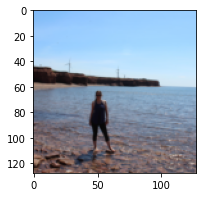

Truth: scene 	 Prediction: scene 	 Result: Right


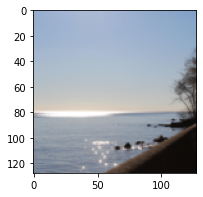

Truth: scene 	 Prediction: scene 	 Result: Right


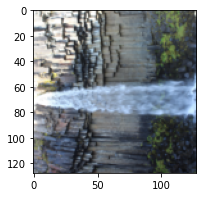

Truth: person 	 Prediction: person 	 Result: Right


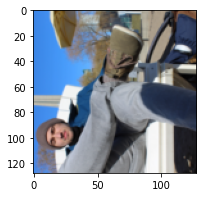

Truth: scene 	 Prediction: scene 	 Result: Right


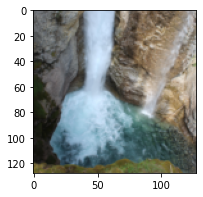

Truth: person 	 Prediction: scene 	 Result: Wrong


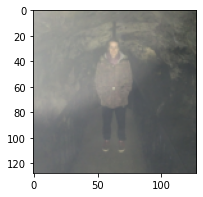

Truth: person 	 Prediction: scene 	 Result: Wrong


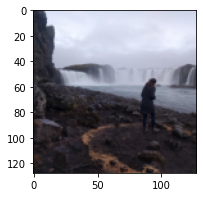

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Truth: person 	 Prediction: person 	 Result: Right


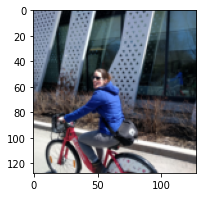

In [20]:
#load a batch from the test set
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

#generate predictions of testloader samples
cnn.eval()
outputs = cnn(images)

#the class with the highest energy is what we choose as prediction
_, predicted = torch.max(outputs, 1)

for i in range(batch_size):
    if classes[labels[i]] == classes[predicted[i]]:
        boolean = 'Right'
    else:
        boolean = 'Wrong'
    print(f'Truth: {classes[labels[i]]} \t Prediction: {classes[predicted[i]]} \t Result: {boolean}')
    imshow(images[i])

#### Complete testset

In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = cnn(data)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 597 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 597 test images: 80 %


### Script Runtime Result

In [22]:
#End Time of Training
script_end = end_time_()

#Time needed for script
print(f'Execution time of script is : {Execution_time(script_start, script_end)} hh:mm:ss')

Execution time of script is : 00:11:57 hh:mm:ss
